Parsing SUMO edges from test_scenarios/CheshireBridgeRd/plain.edg.xml with offset (-744573.44, -3744834.81) and CRS +proj=utm +zone=16 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
⚠️ Road R000: no matching edges found
⚠️ Road R001: no matching edges found
⚠️ Road R002: no matching edges found
⚠️ Road R003: no matching edges found
⚠️ Road R004: no matching edges found


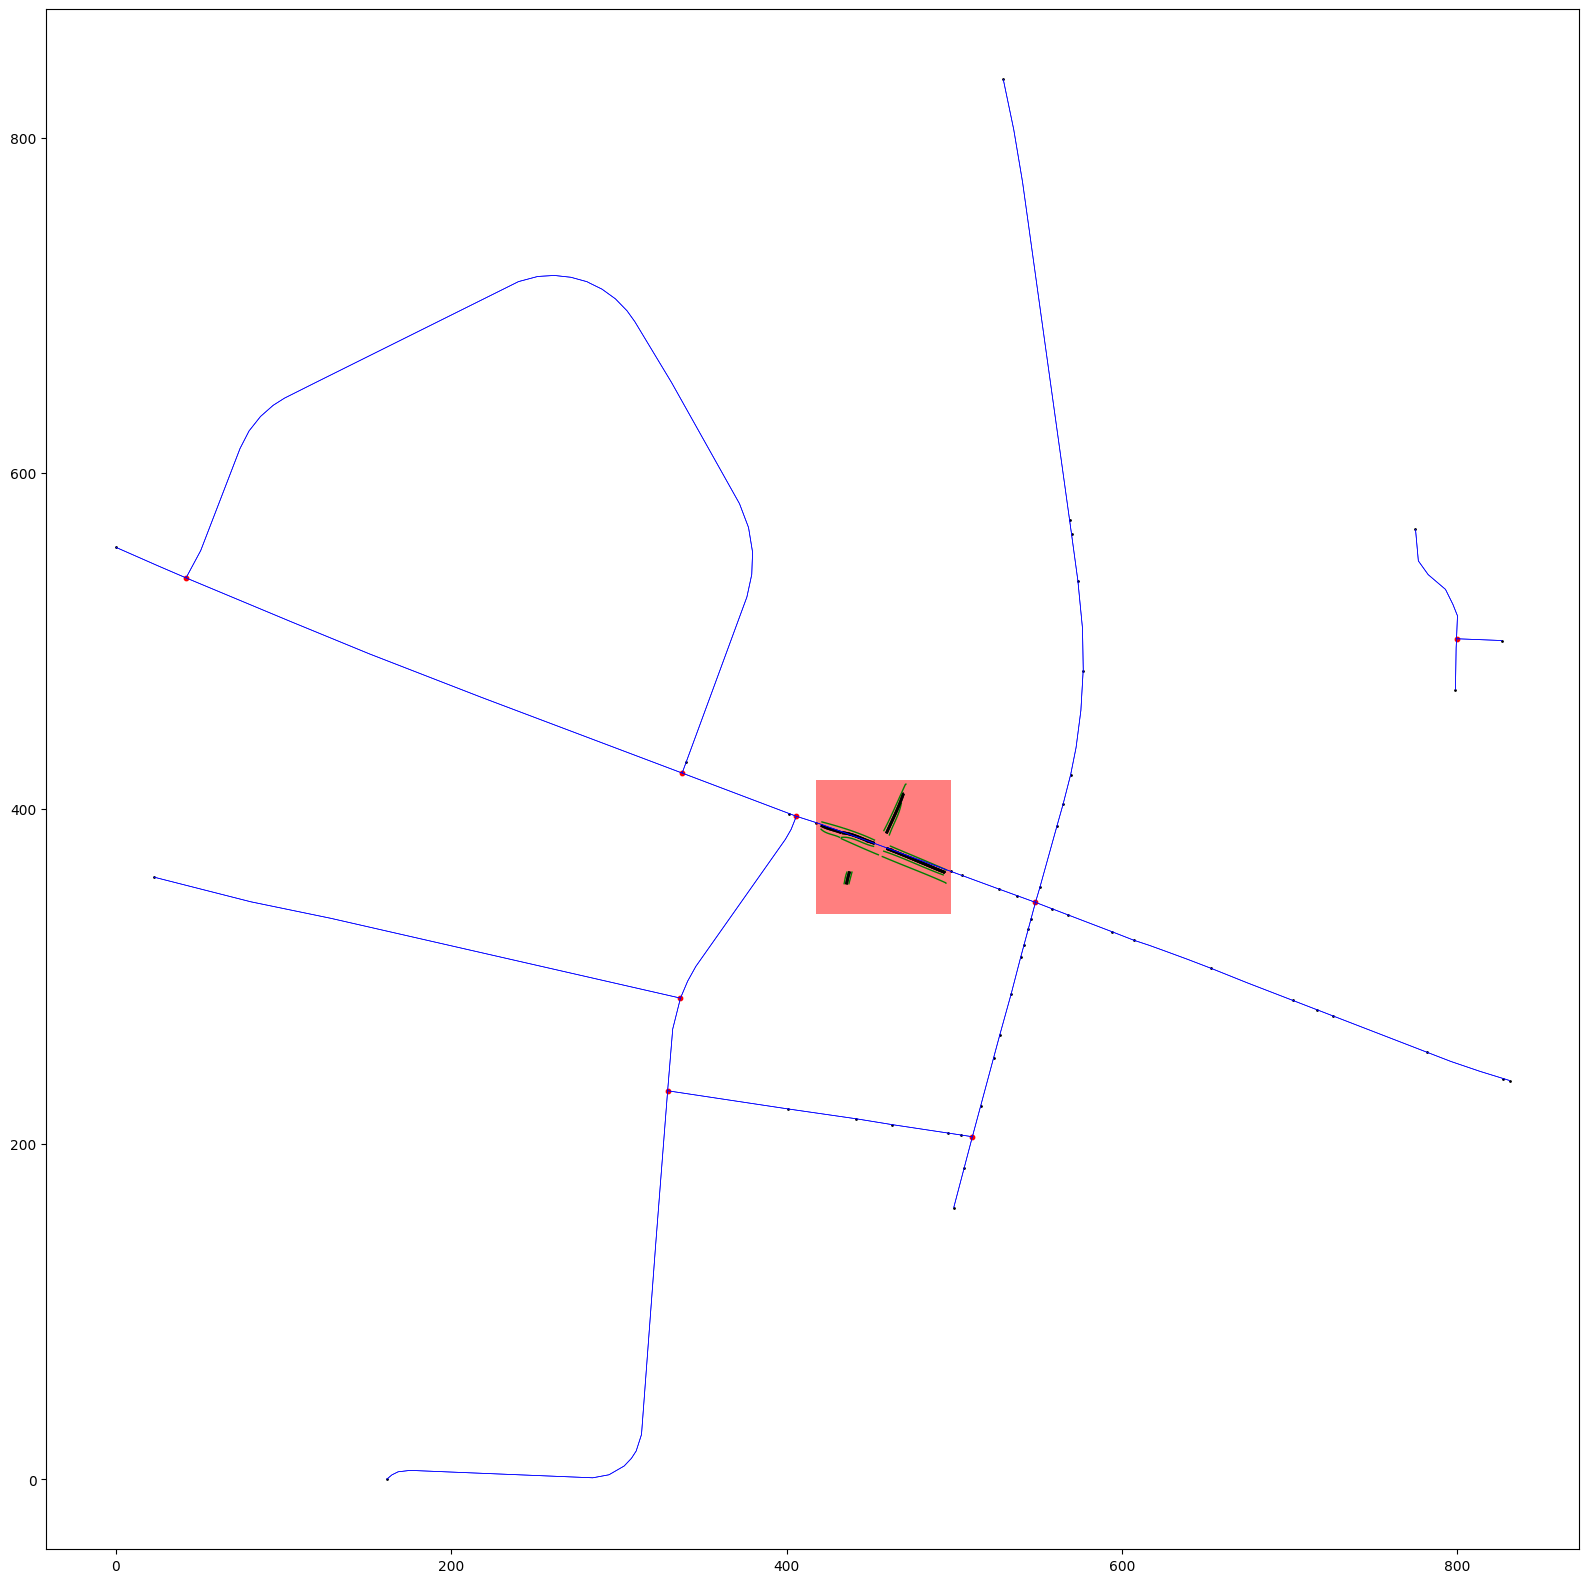

In [14]:
from email.mime import base
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from typing import Dict, Tuple
from pyproj import CRS, Transformer
from shapely.ops import substring
from shapely.affinity import translate
from shapely.geometry import LineString, Point, Polygon
from utils.directional_match import match_reference_line_to_sumo_edges_directional
from utils.sumo_data_classes import SUMONode, SUMOEdge, SUMOConnection, SUMOLane
from utils.network_parse_utils import parse_SUMO_edges, parse_SUMO_connections, parse_SUMO_nodes
GROUND_SAMPLING_DISTANCE = 0.125  # meters per pixel
SATELLITE_IMAGE_HEIGHT = 640  # pixels
SATELLITE_IMAGE_WIDTH = 640  # pixels

class SUMONet():

    def __init__(self, SUMO_nodes_dict: Dict[str, SUMONode], 
                 SUMO_edges_dict: Dict[str, SUMOEdge],
                 SUMO_connections_from_to_dict: Dict[str, SUMOConnection],
                 SUMO_connections_to_from_dict: Dict[str, SUMOConnection],
                 net_offset: tuple[float, float],
                 crs_proj: CRS):

        self.net_offset = net_offset
        self.crs_proj = crs_proj
        self.edges_dict = SUMO_edges_dict
        self.nodes_dict = SUMO_nodes_dict
        self.edges_gdf = SUMONet.sumo_edges_dict_to_gdf(SUMO_edges_dict, SUMO_nodes_dict, crs_proj=self.crs_proj)
        self.nodes_gdf = SUMONet.sumo_nodes_dict_to_gdf(SUMO_nodes_dict, crs_proj=self.crs_proj)
        self.connections_from_to_dict = SUMO_connections_from_to_dict
        self.connections_to_from_dict = SUMO_connections_to_from_dict
        self.new_node_cnt = 0
        self.new_edge_cnt = 0

    @staticmethod
    def sumo_edges_dict_to_gdf(SUMO_edges_dict: Dict[str, SUMOEdge], SUMO_nodes_dict: Dict[str, SUMONode], crs_proj: CRS) -> gpd.GeoDataFrame:
        features = []
        for edge in SUMO_edges_dict.values():
            geom = []
            from_node = SUMO_nodes_dict.get(edge.from_node)
            to_node = SUMO_nodes_dict.get(edge.to_node)
            edge_coordinates = edge.shape_string_to_coordinates()
            geom = [(from_node.x, from_node.y), *edge_coordinates, (to_node.x, to_node.y)]

            feature = {
                "geometry": LineString(geom),
                "id": edge.id,
                "from": edge.from_node,
                "to": edge.to_node,
                "type": edge.edge_type,
                "numLanes": edge.numLanes,
                "disallow": edge.disallow
            }
            features.append(feature)
        return gpd.GeoDataFrame(features, crs=crs_proj)

    @staticmethod
    def sumo_nodes_dict_to_gdf(SUMO_nodes_dict: Dict[str, SUMONode], crs_proj: CRS) -> gpd.GeoDataFrame:
        features = []
        for node in SUMO_nodes_dict.values():
            feature = {
                "geometry": Point(node.x, node.y),
                "id": node.id,
                "type": node.node_type
            }
            features.append(feature)
        return gpd.GeoDataFrame(features, crs=crs_proj)

    @staticmethod
    def make_sumo_converter(proj_str, net_offset):
        """
        Returns two functions: 
          sumo_xy_to_lonlat(x, y) and lonlat_to_sumo_xy(lon, lat)
        proj_str: full projParameter string from SUMO <location> tag
        net_offset: tuple (offset_x, offset_y) from SUMO <location> tag
        """
        crs_src = CRS.from_proj4(proj_str)      # source: SUMO's projected CRS
        crs_dst = CRS.from_epsg(4326)           # target: WGS84 lat/lon

        to_lonlat = Transformer.from_crs(crs_src, crs_dst, always_xy=True)
        to_proj   = Transformer.from_crs(crs_dst, crs_src, always_xy=True)

        net_offset_x, net_offset_y = net_offset

        def sumo_xy_to_lonlat(x, y):
            X_proj = x + net_offset_x
            Y_proj = y + net_offset_y
            lon, lat = to_lonlat.transform(X_proj, Y_proj)
            return lon, lat

        def lonlat_to_sumo_xy(lon, lat):
            X_proj, Y_proj = to_proj.transform(lon, lat)
            x = X_proj - net_offset_x
            y = Y_proj - net_offset_y
            return x, y

        return sumo_xy_to_lonlat, lonlat_to_sumo_xy

    @staticmethod
    def if_two_lines_are_along_same_direction(line1: LineString, line2: LineString) -> bool:
        # Calculate the direction vectors of both lines using their start and end points
        line1_start, line1_end = line1.coords[0], line1.coords[-1]
        line2_start, line2_end = line2.coords[0], line2.coords[-1]
        vec1 = (line1_end[0] - line1_start[0], line1_end[1] - line1_start[1])
        vec2 = (line2_end[0] - line2_start[0], line2_end[1] - line2_start[1])
        
        # Calculate the dot product
        dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]
        
        # If the dot product is positive, the lines are along the same direction
        return dot_product > 0
    
    @staticmethod
    def find_intersected_points_with_region(line: LineString, region_polygon: Polygon) -> list[Point]:
        intersected_points = line.intersection(region_polygon)
        if intersected_points.is_empty:
            return []
        elif intersected_points.geom_type == 'Point':
            return [intersected_points]
        elif intersected_points.geom_type == 'MultiPoint':
            return list(intersected_points.geoms)
        else:
            raise ValueError(f"Invalid intersection geometry: {intersected_points.geom_type}")
        
    def get_nodes_degree_dict(self) -> Dict[str, int]:
        in_degree_dict = {}
        out_degree_dict = {}
        for edge in self.edges_dict.values():
            out_degree_dict[edge.from_node] = out_degree_dict.get(edge.from_node, 0) + 1
            in_degree_dict[edge.to_node] = in_degree_dict.get(edge.to_node, 0) + 1
        return in_degree_dict, out_degree_dict

    def get_intersection_nodes_gdf(self) -> gpd.GeoDataFrame:
        in_degree_dict, out_degree_dict = self.get_nodes_degree_dict()
        intersection_nodes = [node_id for node_id, degree in in_degree_dict.items() if degree > 2]
        return self.nodes_gdf[self.nodes_gdf['id'].isin(intersection_nodes)]

    def remove_isolated_nodes(self):
        # Remove nodes that are not connected to any edge
        connected_nodes = set(self.edges_gdf['from']).union(set(self.edges_gdf['to']))
        self.nodes_gdf = self.nodes_gdf[self.nodes_gdf['id'].isin(connected_nodes)]
        self.nodes_dict = {k: v for k, v in self.nodes_dict.items() if k in connected_nodes}
    
    def find_intersected_edges(self, region_polygon: Polygon) -> gpd.GeoDataFrame:
        # Find edges that intersect with the given region
        return self.edges_gdf[self.edges_gdf.intersects(region_polygon)]

    def find_edges_with_both_nodes_within(self, region_polygon: Polygon) -> gpd.GeoDataFrame:
        # Find edges that have both nodes within the given region

        nodes_within = self.find_nodes_within(region_polygon)
        return self.edges_gdf[self.edges_gdf['from'].isin(nodes_within['id']) & self.edges_gdf['to'].isin(nodes_within['id'])]

    def find_nodes_within(self, region_polygon: Polygon) -> gpd.GeoDataFrame:
        # Find nodes that are within the given chip
        return self.nodes_gdf[self.nodes_gdf.within(region_polygon)]

    def build_intersection_chip(self, x, y, width, height):
        # the x y coresponds to the center of the chip in sumo cooridnate
        # the height and width are in the meters
        # this function returns the shape of the resutling chip (Polygon)

        chip = Polygon([
            (x - width / 2, y - height / 2),
            (x + width / 2, y - height / 2),
            (x + width / 2, y + height / 2),
            (x - width / 2, y + height / 2)
        ])

        return chip

    def add_connection(self, from_edge: str, to_edge: str, from_lane: str, to_lane: str):
        
        connection = SUMOConnection(
            from_edge=from_edge,
            to_edge=to_edge,
            from_lane=from_lane,
            to_lane=to_lane
        )
        self.connections_from_to_dict[connection.from_edge] = connection
        self.connections_to_from_dict[connection.to_edge] = connection
        
    def remove_edge(self, edge_id: str):
        if edge_id not in self.edges_dict:
            raise ValueError(f"Edge {edge_id} not found in edges_dict")
        if edge_id not in self.edges_gdf['id'].values:
            raise ValueError(f"Edge {edge_id} not found in edges_gdf")
        # remove from the edges_dict and edges_gdf
        self.edges_dict.pop(edge_id)
        self.edges_gdf = self.edges_gdf[self.edges_gdf['id'] != edge_id]
        # remove the related connections
        self.connections_from_to_dict.pop(edge_id, None)
        self.connections_to_from_dict.pop(edge_id, None)
        
    def add_new_edge(self, edge_id: str, from_node_id: str, to_node_id: str, edge_geometry:LineString, additional_attributes):
        
        new_edge_row = gpd.GeoDataFrame([{"id": edge_id, "from": from_node_id, "to": to_node_id, **additional_attributes, "geometry": edge_geometry}],
                                          geometry="geometry", 
                                          crs=self.edges_gdf.crs,
                                          index=[0])
        self.edges_gdf = pd.concat([self.edges_gdf, new_edge_row], ignore_index=True)
        self.edges_dict[edge_id] = SUMOEdge(id=edge_id, from_node=from_node_id, to_node=to_node_id)
        coordinates = [(float(pt[0]), float(pt[1])) for pt in edge_geometry.coords]
        self.edges_dict[edge_id].coordinates_to_shape_string(coordinates)

    def update_edge_num_lanes(self, edge_id: str, new_num_lanes: int):

        self.edges_dict[edge_id].numLanes = new_num_lanes
        self.edges_dict[edge_id].lanes = {str(i): SUMOLane(index=str(i)) for i in range(new_num_lanes)}
        self.edges_gdf.loc[self.edges_gdf['id'] == edge_id, 'numLanes'] = new_num_lanes


    def split_edge_at_point(self, edge_id: str, 
                            adding_point: Point, 
                            new_node_distance_threshold: float = 2.0):

        row = self.edges_gdf.loc[self.edges_gdf["id"] == edge_id].iloc[0]
        new_node_id, added_new_node = self.add_node(adding_point.x, adding_point.y, node_type="priority", new_node_distance_threshold=new_node_distance_threshold)

        
         # create two new edges
        from_node1, to_node1 = row["from"], new_node_id
        geometry1 = LineString([self.nodes_gdf.loc[self.nodes_gdf["id"] == from_node1, "geometry"].values[0],
                                self.nodes_gdf.loc[self.nodes_gdf["id"] == to_node1, "geometry"].values[0]])
        edge_id1 = f"{edge_id}_1"
        from_node2, to_node2 = new_node_id, row["to"]
        geometry2 = LineString([self.nodes_gdf.loc[self.nodes_gdf["id"] == from_node2, "geometry"].values[0],
                                self.nodes_gdf.loc[self.nodes_gdf["id"] == to_node2, "geometry"].values[0]])
        edge_id2 = f"{edge_id}_2"
    
        additional_attributes = {k: row[k] for k in row.index if k not in ["id", "from", "to", "geometry"]}
        self.remove_edge(edge_id)
        self.add_new_edge(edge_id1, from_node1, to_node1, geometry1, additional_attributes)
        self.add_new_edge(edge_id2, from_node2, to_node2, geometry2, additional_attributes)

        return edge_id1, edge_id2, new_node_id
    
    def rebuild_intersection(self, intersection_center: Tuple[float, float]) -> None:
        intersection_center_x, intersection_center_y = intersection_center
        new_node_id, added_new_node = self.add_node(intersection_center_x, intersection_center_y, node_type="traffic_light", new_node_distance_threshold=2.0)
        intersection_node = self.nodes_dict[new_node_id]
        
        
        chip = self.build_intersection_chip(intersection_center_x, intersection_center_y, 80, 80)
        # Find all intersected edges
        intersected_edges = self.find_intersected_edges(chip.boundary)
        # Find all intersected edges with both nodes within the chip
        edges_with_both_nodes = self.find_edges_with_both_nodes_within(chip)
        # Since we only care the edges that go through the chip, we may call it key edges here
        key_edges = intersected_edges[~intersected_edges['id'].isin(edges_with_both_nodes['id'])]

        nodes_within_chip = self.find_nodes_within(chip)

        # The candidate edges can be viewed as edges that crossing the chip, and with one node added at the intersecting point, the other end is calculated based on the reference line
        candidate_edge_gdf = gpd.GeoDataFrame(columns=['from_node', 'to_node', 'old_edge_id', 'should_connect_from_new_edge_to_old_edge'])
        for edge_id in key_edges['id'].unique():
            edge = key_edges.loc[key_edges['id'] == edge_id].iloc[0]
            edge_geom = edge.geometry

            # Find intersection points
            intersected_points = SUMONet.find_intersected_points_with_region(edge_geom, chip.boundary)
            for intersected_point in intersected_points:
                                # the edge should be splited, adding the new node
                # the candidate node pair are whose geometery and num of lanes should be determined through the lane extraction model
                candidate_edge_nodes_pair, old_edge_id, should_connect_from_new_edge_to_old_edge = self.split_edge_at_point_intersection(edge_id,
                                                                                                                            intersected_point,
                                                                                                                            intersection_node,
                                                                                                                            nodes_within_chip)
                from_node, to_node = candidate_edge_nodes_pair
                new_row = gpd.GeoDataFrame({
                    'edge_id': f"E_new_{self.new_edge_cnt}",
                    'from_node': from_node,
                    'to_node': to_node,
                    'old_edge_id': old_edge_id,
                    'should_connect_from_new_edge_to_old_edge': should_connect_from_new_edge_to_old_edge,
                    'geometry': LineString([self.nodes_gdf.loc[self.nodes_gdf["id"] == from_node, "geometry"].values[0],
                                    self.nodes_gdf.loc[self.nodes_gdf["id"] == to_node, "geometry"].values[0]])
                }, index=[0], crs=self.edges_gdf.crs, geometry='geometry')
                self.new_edge_cnt += 1
                candidate_edge_gdf = pd.concat([candidate_edge_gdf, new_row], ignore_index=True)
        
        candidate_edge_gdf.set_geometry('geometry', inplace=True)
        candidate_edge_gdf.crs = self.edges_gdf.crs
        # also we want remove the edges that both nodes are within the chip
        self.edges_gdf = self.edges_gdf[~self.edges_gdf['id'].isin(edges_with_both_nodes['id'])]
        # also we need to remove the coresponding connections
        self.connections_from_to_dict = {k: v for k, v in self.connections_from_to_dict.items() if k not in edges_with_both_nodes['id']}
        self.connections_to_from_dict = {k: v for k, v in self.connections_to_from_dict.items() if k not in edges_with_both_nodes['id']}
        # also if a node is not connected to any edge, then the node should be removed
        
        

        gdf_lanes = gpd.read_parquet("lanes.parquet")

        reference_lines = {}
        
         # this should be modfied, the offset should be directly from the SUMO network
        # thie is the offset between sumo coodinate and the local coodinate of the XODR
        for road_id, group in gdf_lanes.groupby('road_id'):
            row = group.iloc[0]
            reference_lines[road_id] = row['reference_geom']
            # add offset to reference line
            reference_lines[road_id] = translate(reference_lines[road_id], xoff=offset[0], yoff=offset[1])

        for edge_id, group_edge in candidate_edge_gdf.groupby('edge_id'):
            row = group_edge.iloc[0]
            edge_geom = row['geometry']
            # find the closest reference line
            closest_road_id = None
            closest_distance = float('inf')
            for road_id, ref_line in reference_lines.items():
                distance = edge_geom.hausdorff_distance(ref_line)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_road_id = road_id
            # assign back the road id
            candidate_edge_gdf.loc[candidate_edge_gdf['edge_id'] == edge_id, 'road_id'] = closest_road_id
            print(f"Edge {edge_id} closest to road {closest_road_id} at distance {closest_distance:.3g}")

        for edge_id, group_edge in candidate_edge_gdf.groupby('edge_id'):
            edge_geom = group_edge.iloc[0].geometry
            closest_road_id = group_edge.iloc[0].road_id  # already assigned above
            ref_line = reference_lines[closest_road_id]
            along_same_direction = SUMONet.if_two_lines_are_along_same_direction(edge_geom, ref_line)

            side = "right" if along_same_direction else "left"

            related_lanes = gdf_lanes[(gdf_lanes['road_id']==closest_road_id) &
                                      (gdf_lanes['lane_side']==side)]

            if related_lanes.empty:
                print(f"⚠️ Edge {edge_id}: no {side}-side lanes found on road {closest_road_id}")
                continue
            
            # assign edge_id and lane indices
            gdf_lanes.loc[related_lanes.index, 'edge_id'] = edge_id
            gdf_lanes.loc[related_lanes.index, 'sumo_lane_index'] = (
                related_lanes['avg_offset'].abs().rank(method='first').astype(int) - 1
            )
            print(f"Edge {edge_id} assigned to {len(related_lanes)} {side}-side lanes")

        gdf_links = gpd.read_parquet("links.parquet")
        # then according to the gdf links, the SUMO connection of the new lanes should be established
        for link_idx, link_row in gdf_links.iterrows():
            from_fid = link_row['from_fid']
            to_fid = link_row['to_fid']
            from_lane = gdf_lanes[gdf_lanes['fid'] == from_fid]
            to_lane = gdf_lanes[gdf_lanes['fid'] == to_fid]
            from_edge_id = from_lane['edge_id'].values[0] if not from_lane.empty else None
            to_edge_id = to_lane['edge_id'].values[0] if not to_lane.empty else None
            from_lane_index = from_lane['sumo_lane_index'].values[0] if not from_lane.empty else None
            to_lane_index = to_lane['sumo_lane_index'].values[0] if not to_lane.empty else None
            self.add_connection(from_edge_id, to_edge_id, from_lane_index, to_lane_index)
            
        # Add the candidate edge to the sumo network
        for edge_idx, edge_row in candidate_edge_gdf.iterrows():
            should_connect_from_new_edge_to_old_edge = edge_row['should_connect_from_new_edge_to_old_edge']
            from_node_id = edge_row['from_node']
            to_node_id = edge_row['to_node']
            
            road_id = edge_row['road_id']
            ori_edge_geometry = edge_row['geometry']

            reference_line = reference_lines[road_id]
            
            along_same_direction = SUMONet.if_two_lines_are_along_same_direction(ori_edge_geometry, reference_line)
            # Determine if the edge is along or opposite the reference line
            opposite_along_reference_line = not along_same_direction

            from_node_point = self.nodes_gdf.loc[self.nodes_gdf['id'] == from_node_id, 'geometry'].values[0]
            to_node_point = self.nodes_gdf.loc[self.nodes_gdf['id'] == to_node_id, 'geometry'].values[0]
            

            # depends on the direction, one of the nodes position should be updated with the reference lines end points
            if should_connect_from_new_edge_to_old_edge:
                ori_geometry = self.nodes_gdf.loc[self.nodes_gdf['id'] == from_node_id, 'geometry'].values[0]
                if opposite_along_reference_line:
                    # road length, distance between from node and to node
                    new_from_node_point = Point(reference_line.coords[-1])
                    road_length = new_from_node_point.distance(to_node_point)
                    # cut the original edge geometry with road length
                    new_edge_geometry = substring(ori_edge_geometry, ori_edge_geometry.length-road_length, ori_edge_geometry.length)
                else:
                    new_from_node_point = Point(reference_line.coords[0])
                    road_length = new_from_node_point.distance(to_node_point)
                    new_edge_geometry = substring(ori_edge_geometry, ori_edge_geometry.length-road_length, ori_edge_geometry.length)
                    
            else:
                ori_geometry = self.nodes_gdf.loc[self.nodes_gdf['id'] == to_node_id, 'geometry'].values[0]
                if opposite_along_reference_line:
                    new_to_node_point = Point(reference_line.coords[0])
                    road_length = from_node_point.distance(new_to_node_point)
                    new_edge_geometry = substring(ori_edge_geometry, 0, road_length)
                else:
                    new_to_node_point = Point(reference_line.coords[-1])
                    road_length = from_node_point.distance(new_to_node_point)
                    new_edge_geometry = substring(ori_edge_geometry, 0, road_length)
            print(f"road length: {new_edge_geometry.length}, original length: {ori_edge_geometry.length}")

            related_lanes = gdf_lanes[gdf_lanes['edge_id'] == edge_row['edge_id']]
            lanes_dict = {}
            for lanes_idx, lanes_row in related_lanes.iterrows():
                lane_index = str(int(lanes_row['sumo_lane_index']))
                lane = SUMOLane(
                    index=lane_index,
                )
                lanes_dict[lane_index] = lane

            edge = SUMOEdge(
                id=edge_row['edge_id'],
                from_node=from_node_id,
                to_node=to_node_id,
                numLanes=len(related_lanes),
                shape="",
                disallow=None,
                allow=None
            )
            edge.coordinates_to_shape_string(list(new_edge_geometry.coords))
            edge.lanes.update(lanes_dict)
            self.edges_gdf = pd.concat([self.edges_gdf, gpd.GeoDataFrame({
                "geometry": new_edge_geometry,
                "id": edge.id,
                "from": edge.from_node,
                "to": edge.to_node,
                "type": edge.edge_type,
                "numLanes": edge.numLanes,
                "disallow": edge.disallow
            }, index=[0], crs=self.edges_gdf.crs)], ignore_index=True)
            # print(self.edges_gdf[self.edges_gdf['id'] == edge.id])
            self.edges_dict[edge.id] = edge

        print("Edges processed:", len(self.edges_dict))
        self.edges_dict = {k: v for k, v in self.edges_dict.items() if k in self.edges_gdf['id'].values}
        print("Edges retained:", len(self.edges_dict))
        self.remove_isolated_nodes()

    def split_edge_at_point_intersection(self, edge_id: str, 
                            intersected_point: Point, 
                            intersection_node: SUMONode, # center of the intersection
                            nodes_within: gpd.GeoDataFrame,):

        row = self.edges_gdf.loc[self.edges_gdf["id"] == edge_id].iloc[0]

        new_node_id, added_new_node = self.add_node(intersected_point.x, intersected_point.y, node_type="traffic_light", new_node_distance_threshold=2.0)
        
        candicate_edge_nodes_pair = ("", "")

        should_connect_from_new_edge_to_old_edge = False
        if row["from"] in nodes_within['id'].values:
            from_node = new_node_id
            to_node = row["to"]
            candicate_edge_nodes_pair = (intersection_node.id, new_node_id)
            should_connect_from_new_edge_to_old_edge = True
        else:
            from_node = row["from"]
            to_node = new_node_id
            candicate_edge_nodes_pair = (new_node_id, intersection_node.id)
            should_connect_from_new_edge_to_old_edge = False
        # generate geometry based on from and to node
        geometry = LineString([self.nodes_gdf.loc[self.nodes_gdf["id"] == from_node, "geometry"].values[0],
                                self.nodes_gdf.loc[self.nodes_gdf["id"] == to_node, "geometry"].values[0]])

        additional_attributes = {k: row[k] for k in row.index if k not in ["id", "from", "to", "geometry"]}
        

        self.remove_edge(edge_id)
        self.add_new_edge(edge_id, from_node, to_node, geometry, additional_attributes)
        
        return candicate_edge_nodes_pair, edge_id, should_connect_from_new_edge_to_old_edge

    def add_node(self, x: float, y: float, node_type: str = "priority", new_node_distance_threshold: float = 2.0) -> str:
        # if there is existing node in the nodes_gdf within the distance threshold, not creating the new node but use the closest one
        node_point = Point(x, y)
        existing_nodes = self.nodes_gdf[self.nodes_gdf.geometry.distance(node_point) < new_node_distance_threshold]
        added_new_node = False
        if not existing_nodes.empty:
            closest_node = existing_nodes.loc[existing_nodes.geometry.distance(node_point).idxmin()]
            new_node_id = closest_node['id']
        else:
            new_node_id = f"N_{self.new_node_cnt}"
            new_node = gpd.GeoDataFrame(
                [{"id": new_node_id, "geometry": Point(x, y), "type": node_type}],
                geometry="geometry", crs=self.nodes_gdf.crs
            )
            self.nodes_gdf = pd.concat([self.nodes_gdf, new_node], ignore_index=True)
            self.nodes_dict[new_node_id] = SUMONode(id=new_node_id, x=x, y=y, node_type=node_type)
            self.new_node_cnt += 1
            added_new_node = True

        return new_node_id, added_new_node

    def update_edge(self, edge_id: str, new_node: str, mode: str = "from") -> None:
        
        def update_edge_geometry(edge_id: str, mode: str) -> None:
            edge_row = self.edges_gdf[self.edges_gdf['id'] == edge_id].iloc[0]
            from_node = edge_row['from']
            to_node = edge_row['to']
            
            original_geometry = edge_row['geometry']
            # the newgeometry should be a substring of the original geometry with the new length
            new_length = self.nodes_gdf.loc[self.nodes_gdf['id'] == from_node, 'geometry'].values[0].distance(
                self.nodes_gdf.loc[self.nodes_gdf['id'] == to_node, 'geometry'].values[0]
            )
            
            if mode == "from":
                new_geometry = substring(original_geometry, original_geometry.length - new_length, original_geometry.length)
            else:
                new_geometry = substring(original_geometry, 0, new_length)
            # the end points should be updated to the new nodes
            new_geometry[0] = (self.nodes_gdf.loc[self.nodes_gdf['id'] == from_node, 'geometry'].values[0].x,
                               self.nodes_gdf.loc[self.nodes_gdf['id'] == from_node, 'geometry'].values[0].y)
            
            new_geometry[-1] = (self.nodes_gdf.loc[self.nodes_gdf['id'] == to_node, 'geometry'].values[0].x,
                                self.nodes_gdf.loc[self.nodes_gdf['id'] == to_node, 'geometry'].values[0].y)
            self.edges_gdf.loc[self.edges_gdf['id'] == edge_id, 'geometry'] = new_geometry
            coordinates = [(float(pt[0]), float(pt[1])) for pt in new_geometry.coords]
            self.edges_dict[edge_id].coordinates_to_shape_string(coordinates)
        
        
        if edge_id not in self.edges_dict:
            raise ValueError(f"Edge {edge_id} not found in edges_dict")
        if mode == "from":
            self.edges_dict[edge_id].from_node = new_node
            self.edges_gdf.loc[self.edges_gdf['id'] == edge_id, 'from'] = new_node
            update_edge_geometry(edge_id, mode)
        elif mode == "to":
            self.edges_dict[edge_id].to_node = new_node
            self.edges_gdf.loc[self.edges_gdf['id'] == edge_id, 'to'] = new_node
            update_edge_geometry(edge_id, mode)
    
    
    def rebuild_non_intersection(self, non_intersection_center: Tuple[float, float], lanes_gdf: gpd.GeoDataFrame) -> None:
        non_intersection_center_x, non_intersection_center_y = non_intersection_center

        chip = self.build_intersection_chip(non_intersection_center_x, non_intersection_center_y, 80, 80)
        # Find all intersected edges
        intersected_edges = self.find_intersected_edges(chip.boundary)
        # Find all intersected edges with both nodes within the chip
        edges_with_both_nodes_within = self.find_edges_with_both_nodes_within(chip)
        key_edges = intersected_edges[~intersected_edges['id'].isin(edges_with_both_nodes_within['id'])]
        
        
        offset_non_intersection = (423, 355)
        # shift the lanes gdf with the offset
        lanes_gdf['geometry'] = lanes_gdf['geometry'].apply(lambda geom: translate(geom, xoff=offset_non_intersection[0], yoff=offset_non_intersection[1]))
        lanes_gdf['reference_geom'] = lanes_gdf['reference_geom'].apply(lambda geom: translate(geom, xoff=offset_non_intersection[0], yoff=offset_non_intersection[1]))
        nodes_within_chip = self.find_nodes_within(chip)

        for edge_id in key_edges['id'].unique():
            edge = key_edges.loc[key_edges['id'] == edge_id].iloc[0]
            edge_geom: LineString = edge.geometry

            # Find intersection points
            intersected_points = SUMONet.find_intersected_points_with_region(edge_geom, chip.boundary)
            for intersected_point in intersected_points:
                self.split_edge_at_point(edge_id, intersected_point)

        reference_lines = {}
        for road_id, group in lanes_gdf.groupby('road_id'):
            row = group.iloc[0]
            reference_lines[road_id] = row['reference_geom']

        for road_id, reference_line in reference_lines.items():
            res = match_reference_line_to_sumo_edges_directional(
                self.edges_gdf,
                reference_line,
                edge_id_col='id',
                angle_thresh_deg=10.0,  # stricter alignment
                dist_thresh=5.0,        # within ~10 m of the edges
                sample_spacing=2.0,     # denser sampling along the ref
                include_reverse_path=True
            )
            forward_edges = res["ordered_edge_ids_forward"]
            reverse_edges = res["ordered_edge_ids_reverse"]
            if len(forward_edges) == 0 or len(reverse_edges) == 0:
                # no matching edges found means that the reference line does not correspond to any SUMO edge
                print(f"⚠️ Road {road_id}: no matching edges found")
                continue
            # along the reference line direction
            start_node_x, start_node_y = res['projected_start_forward']
            end_node_x, end_node_y = res['projected_end_forward']
            start_edge_id = res['start_edge_id_forward']
            end_edge_id = res['end_edge_id_forward']
            # reverse the direction
            start_node_x_rev, start_node_y_rev = res['projected_end_reverse']
            end_node_x_rev, end_node_y_rev = res['projected_start_reverse']
            start_edge_id_rev = res['start_edge_id_reverse']
            end_edge_id_rev = res['end_edge_id_reverse']
            # for the simplicity of the resulting network, there should be only one pair of endpoints
            
            start_node_point = Point((start_node_x + start_node_x_rev) / 2, (start_node_y + start_node_y_rev) / 2)
            end_node_point = Point((end_node_x + end_node_x_rev) / 2, (end_node_y + end_node_y_rev) / 2)
            
            # split the start edge and end edge to connect to the new nodes
            _, start_edge_part2_id, start_node_id = self.split_edge_at_point(start_edge_id, start_node_point)
            if len(forward_edges) == 1:
                end_edge_part1_id, _, end_node_id = self.split_edge_at_point(start_edge_part2_id, end_node_point)
            else:
                end_edge_part1_id, _, end_node_id = self.split_edge_at_point(end_edge_id, end_node_point)
            forward_edges[0] = start_edge_part2_id
            forward_edges[-1] = end_edge_part1_id

            _, end_edge_part2_id_rev, start_node_id_rev = self.split_edge_at_point(start_edge_id_rev, end_node_point)
            if len(reverse_edges) == 1:
                start_edge_part1_id_rev, _, end_node_id_rev = self.split_edge_at_point(end_edge_part2_id_rev, start_node_point)
            else:
                start_edge_part1_id_rev, _, end_node_id_rev = self.split_edge_at_point(end_edge_id_rev, start_node_point)
            reverse_edges[0] = end_edge_part2_id_rev
            reverse_edges[-1] = start_edge_part1_id_rev
            # modify the num_of_lanes_through the edges
            
             
            ## let focus on the forward direction first
            for edge_id in forward_edges:
                edge = self.edges_gdf[self.edges_gdf['id'] == edge_id]
                edge_geom = edge.iloc[0].geometry

                related_lanes = lanes_gdf[(lanes_gdf['road_id']==road_id) &
                                          (lanes_gdf['lane_side']=="right")]

                if related_lanes.empty:
                    # print(f"⚠️ Edge {edge_id}: no {side}-side lanes found on road {road_id}")
                    continue
                self.update_edge_num_lanes(edge_id, len(related_lanes))
                # # assign edge_id and lane indices
                # lanes_gdf.loc[related_lanes.index, 'edge_id'] = edge_id
                # lanes_gdf.loc[related_lanes.index, 'sumo_lane_index'] = (
                #     related_lanes['avg_offset'].abs().rank(method='first').astype(int) - 1
                # )
                print(f"Edge {edge_id} assigned to {len(related_lanes)} right-side lanes")
                # [ ] The connections should be also updated accordingly

            ## then the reverse direction
            for edge_id in reverse_edges:
                edge = self.edges_gdf[self.edges_gdf['id'] == edge_id]
                edge_geom = edge.iloc[0].geometry

                related_lanes = lanes_gdf[(lanes_gdf['road_id']==road_id) &
                                          (lanes_gdf['lane_side']=="left")]

                if related_lanes.empty:
                    # print(f"⚠️ Edge {edge_id}: no {side}-side lanes found on road {road_id}")
                    continue
                self.update_edge_num_lanes(edge_id, len(related_lanes))
                # # assign edge_id and lane indices
                # lanes_gdf.loc[related_lanes.index, 'edge_id'] = edge_id
                # lanes_gdf.loc[related_lanes.index, 'sumo_lane_index'] = (
                #     related_lanes['avg_offset'].abs().rank(method='first').astype(int) - 1
                # )
                print(f"Rev Edge {edge_id} assigned to {len(related_lanes)} left-side lanes")
    
SUMO_nodes_path = "test_scenarios/CheshireBridgeRd/plain.nod.xml"
SUMO_edges_path = "test_scenarios/CheshireBridgeRd/plain.edg.xml"
SUMO_connections_path = "test_scenarios/CheshireBridgeRd/plain.con.xml"
# osm_path = "test_scenarios/CheshireBridgeRd/CheshireBridgeRd.osm"
SUMO_nodes_dict, net_offset, crs_proj = parse_SUMO_nodes(SUMO_nodes_path)
SUMO_edges_dict, net_offset, crs_proj = parse_SUMO_edges(SUMO_edges_path)
SUMO_connections_from_to_dict, SUMO_connections_to_from_dict = parse_SUMO_connections(SUMO_connections_path)

sumo_net = SUMONet(SUMO_nodes_dict, 
                   SUMO_edges_dict,
                   SUMO_connections_from_to_dict=SUMO_connections_from_to_dict,
                   SUMO_connections_to_from_dict=SUMO_connections_to_from_dict,
                   net_offset=net_offset,
                   crs_proj=crs_proj)

get_intersection_nodes_gdf = sumo_net.get_intersection_nodes_gdf()

# actual height and width in meters
actual_height = GROUND_SAMPLING_DISTANCE * SATELLITE_IMAGE_HEIGHT
actual_width = GROUND_SAMPLING_DISTANCE * SATELLITE_IMAGE_WIDTH
non_intersection_center = (457.83, 377.23)


intersection_center = (548.43, 344.03)
fig, ax = plt.subplots(figsize=(20, 20))
lanes_gdf = gpd.read_parquet("lanes.parquet")
# shift the lanes gdf with the offset
lanes_gdf['geometry'] = lanes_gdf['geometry'].apply(lambda geom: translate(geom, xoff=non_intersection_center[0] - actual_width/2, yoff=non_intersection_center[1] + actual_height/2))
lanes_gdf['reference_geom'] = lanes_gdf['reference_geom'].apply(lambda geom: translate(geom, xoff=non_intersection_center[0] - actual_width/2, yoff=non_intersection_center[1] + actual_height/2))
lanes_gdf.plot(ax=ax, color='green', linewidth=1)
lanes_gdf['reference_geom'].plot(ax=ax, color='black', linewidth=2)

sumo_net.rebuild_non_intersection(non_intersection_center, lanes_gdf)
sumo_net.edges_gdf.plot(ax=ax, color='blue', linewidth=0.5)
sumo_net.nodes_gdf.plot(ax=ax, color='black', markersize=1)
get_intersection_nodes_gdf.plot(ax=ax, color='red', markersize=10)
chip = sumo_net.build_intersection_chip(non_intersection_center[0], non_intersection_center[1], actual_height, actual_width)
x, y = chip.exterior.xy

ax.fill(x, y, alpha=0.5, fc='r', ec='none')
# only show a region around the intersection
# ax.set_xlim(non_intersection_center[0]-50, non_intersection_center[0]+50)
# ax.set_ylim(non_intersection_center[1]-50, non_intersection_center[1]+50)
plt.show()



In [38]:
# output the xml file
import xml.etree.ElementTree as ET
output_file = "/home/hetianguo/Desktop/LaneGraph/test_scenarios/CheshireBridgeRd/output_edges_non_intersection.xml"
with open(output_file, "wb") as f:
    root = ET.Element("edges")
    for edge_id, edge in sumo_net.edges_dict.items():
        root.append(edge.get_edge_as_xml())
    tree = ET.ElementTree(root)
    ET.indent(tree, space="  ", level=0)  # Indent the XML for better readability
    tree.write(f, encoding="utf-8", xml_declaration=True)




In [39]:
output_file = "/home/hetianguo/Desktop/LaneGraph/test_scenarios/CheshireBridgeRd/output_nodes_non_intersection.xml"
with open(output_file, "wb") as f:
    root = ET.Element("nodes")
    for node_id, node in sumo_net.nodes_dict.items():
        root.append(node.get_node_as_xml())
    tree = ET.ElementTree(root)
    ET.indent(tree, space="  ", level=0)  # Indent the XML for better readability
    tree.write(f, encoding="utf-8", xml_declaration=True)